In [3]:
!pip install torchtext
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/

In [1]:
import torch
import torchtext
from torchtext import vocab
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [2]:
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

.vector_cache/glove.6B.zip: 862MB [05:18, 2.71MB/s]                           
100%|█████████▉| 399999/400000 [00:20<00:00, 19271.71it/s]


In [3]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# my_collate_function prepares batches
# it also pads each batch with zeroes.
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [4]:
#define the CNN model
class cnnModel(torch.nn.Module):
    def __init__(self, vocab, embedding_size, k1, k2, n1, n2):
        super().__init__()
        # convert word tokens into word vectors
        self.embeddings = nn.Embedding.from_pretrained(vocab.vectors)

        # 2 convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n1, kernel_size=(k1, embedding_size), bias=False)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=n2, kernel_size=(k2, embedding_size), bias=False)

        # activation and maxpool
        self.relu = nn.ReLU()
        self.maxpool = nn.AdaptiveMaxPool1d(1)

        # takes concatenated as input, and output a scalar
        self.linear = nn.Linear(n1+n2, 1)

    def forward(self, x):
        # Now shape transposed to (batch_size, length)
        x = x.transpose(0, 1)

        #(batch_size, length, embedding_dim)
        embedded = self.embeddings(x)

        # add dimension = 1 for convolution
        #(batch_size, 1, length, embedding_dim)
        embedded = embedded.unsqueeze(1)

        #(batch_size, n1, length-k1+1, 1)
        x1 = self.conv1(embedded)
        x1 = self.relu(x1)
        #(batch_size, n1, 1)
        x1 = self.maxpool(x1.squeeze(3))
        #(batch_size, n1)
        x1 = x1.squeeze(2)

        #(batch_size, n2, length-k2+1, 1)
        x2 = self.conv2(embedded)
        x2 = self.relu(x2)
        #(batch_size, n2, 1)
        x2 = self.maxpool(x2.squeeze(3))
        #(batch_size, n2)
        x2 = x2.squeeze(2)

        #(batch_size, n1+n2)
        concatenated = torch.cat((x1, x2), dim=1)
        #(batch_size, 1)
        output = self.linear(concatenated)
        output = torch.nn.Sigmoid()(output)

        #(batch_size)
        return output.reshape(-1)

In [5]:
#define the CNN model(freeze = False)
class cnnFreezeFalseModel(torch.nn.Module):
    def __init__(self, vocab, embedding_size, k1, k2, n1, n2):
        super().__init__()
        # convert word tokens into word vectors
        self.embeddings = nn.Embedding.from_pretrained(vocab.vectors, freeze = False)

        # 2 convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n1, kernel_size=(k1, embedding_size), bias=False)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=n2, kernel_size=(k2, embedding_size), bias=False)

        # activation and maxpool
        self.relu = nn.ReLU()
        self.maxpool = nn.AdaptiveMaxPool1d(1)

        # takes concatenated as input, and output a scalar
        self.linear = nn.Linear(n1+n2, 1)

    def forward(self, x):
        # Now shape transposed to (batch_size, length)
        x = x.transpose(0, 1)

        #(batch_size, length, embedding_dim)
        embedded = self.embeddings(x)

        # add dimension = 1 for convolution
        #(batch_size, 1, length, embedding_dim)
        embedded = embedded.unsqueeze(1)

        #(batch_size, n1, length-k1+1, 1)
        x1 = self.conv1(embedded)
        x1 = self.relu(x1)
        #(batch_size, n1, 1)
        x1 = self.maxpool(x1.squeeze(3))
        #(batch_size, n1)
        x1 = x1.squeeze(2)

        #(batch_size, n2, length-k2+1, 1)
        x2 = self.conv2(embedded)
        x2 = self.relu(x2)
        #(batch_size, n2, 1)
        x2 = self.maxpool(x2.squeeze(3))
        #(batch_size, n2)
        x2 = x2.squeeze(2)

        #(batch_size, n1+n2)
        concatenated = torch.cat((x1, x2), dim=1)
        #(batch_size, 1)
        output = self.linear(concatenated)
        output = torch.nn.Sigmoid()(output)

        #(batch_size)
        return output.reshape(-1)

In [21]:
#5.1 overfit to debug
def overfit(epochs, batch_size, k1 = 2, n1 = 50, k2 = 4, n2 = 50):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    # 3.3.2
    overfit_dataset = TextDataset(glove, "overfit")
    val_dataset = TextDataset(glove, "validation")

    # 3.3.3
    overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    model = cnnModel(glove,100,k1,k2,n1,n2)
    # BCEWithLogitsLoss combines both sigmoid and binary corss-entropy
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    total_trainloss = []
    train_accuracy = []
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        for x_overfit,y_overfit in overfit_dataloader:
            optimizer.zero_grad()
            logits= model(x_overfit)
            loss = loss_function(logits, y_overfit.float())
            epoch_loss += loss.item()
            # backpropagate and update the weights
            loss.backward()
            optimizer.step()

            predicted_labels = (torch.sigmoid(logits) > 0.5).float()
            correct += (predicted_labels == y_overfit).sum().item()
            total += y_overfit.size(0)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(overfit_dataloader)}')
        total_trainloss.append(epoch_loss/len(overfit_dataloader))
        print(f'Epoch {epoch+1}, Train Accuracy: {correct/total}')
        train_accuracy.append(correct/total)

    # validation after training
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x_val, y_val in validation_dataloader:
            outputs = model(x_val)
            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted_labels == y_val).sum().item()
            total += y_val.size(0)

    val_accracy = correct / total

    print(f"final train accuracy: {train_accuracy[-1]}")
    print(f"final validation accuracy: {val_accracy}")
    return total_trainloss, train_accuracy

Using device: cpu
Epoch 1, Train Loss: 0.7228453342731183
Epoch 1, Train Accuracy: 0.46
Epoch 2, Train Loss: 0.5536274474400741
Epoch 2, Train Accuracy: 0.86
Epoch 3, Train Loss: 0.4697597301923312
Epoch 3, Train Accuracy: 1.0
Epoch 4, Train Loss: 0.3745025350497319
Epoch 4, Train Accuracy: 1.0
Epoch 5, Train Loss: 0.297857777430461
Epoch 5, Train Accuracy: 1.0
Epoch 6, Train Loss: 0.22576029082903495
Epoch 6, Train Accuracy: 1.0
Epoch 7, Train Loss: 0.16930093100437751
Epoch 7, Train Accuracy: 1.0
Epoch 8, Train Loss: 0.12551978287788537
Epoch 8, Train Accuracy: 1.0
Epoch 9, Train Loss: 0.09373367749727689
Epoch 9, Train Accuracy: 1.0
Epoch 10, Train Loss: 0.07113047703527488
Epoch 10, Train Accuracy: 1.0
Epoch 11, Train Loss: 0.0552643620623992
Epoch 11, Train Accuracy: 1.0
Epoch 12, Train Loss: 0.043863044263651736
Epoch 12, Train Accuracy: 1.0
Epoch 13, Train Loss: 0.035550606365387254
Epoch 13, Train Accuracy: 1.0
Epoch 14, Train Loss: 0.02939470814397702
Epoch 14, Train Accuracy:

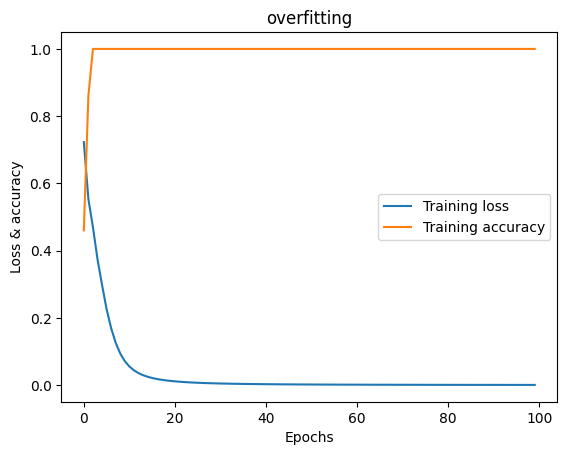

In [11]:
train_loss, train_acc= overfit(epochs=100, batch_size=4)
plt.plot(train_loss, label = "Training loss")
plt.plot(train_acc, label = "Training accuracy")
plt.title("overfitting")
plt.xlabel("Epochs")
plt.ylabel("Loss & accuracy")
plt.legend()
plt.show()

In [40]:
#5.1.1
def main(epochs,batch_size,learningrate,k1,k2,n1,n2):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    # 3.3.2
    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")

    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with
    model = cnnModel(glove,100,k1,k2,n1,n2)
    # BCEWithLogitsLoss combines both sigmoid and binary corss-entropy
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningrate)

    total_trainloss = []
    total_valloss = []
    total_testloss = []
    total_accuracy = []

    for epoch in range(epochs):
        epoch_loss = 0
        for x_train,y_train in train_dataloader:
            optimizer.zero_grad()
            logits= model(x_train)
            loss = loss_function(logits, y_train.float())
            epoch_loss += loss.item()
            # backpropagate and update the weights
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_dataloader)}')
        total_trainloss.append(epoch_loss/len(train_dataloader))

        # validation
        val_loss = 0
        for x_val, y_val in validation_dataloader:
            model.eval()
            with torch.no_grad():
                logits= model(x_val)
            loss = loss_function(logits, y_val.float())
            val_loss += loss.item()
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(validation_dataloader)}')
        total_valloss.append(val_loss/len(validation_dataloader))

        # test and accuracy
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_test,y_test in test_dataloader:
                logits= model(x_test)
                loss = loss_function(logits, y_test.float())

                test_loss += loss.item()

                predicted_labels = (torch.sigmoid(logits) > 0.5).float()
                correct += (predicted_labels == y_test).sum().item()
                total += y_test.size(0)

        print(f'Epoch {epoch+1}, Test Loss: {test_loss/len(test_dataloader)}')
        total_testloss.append(test_loss/len(test_dataloader))
        print(f'Epoch {epoch+1}, Accuracy: {correct/total}')
        total_accuracy.append(correct/total)

    return model, total_trainloss, total_valloss, total_testloss,total_accuracy

in epochs = 50, batch_size = 4, k1 = 2, k2 = 4, n1 = 50, n2 = 80
Using device: cpu
Epoch 1, Train Loss: 0.5781405775994063
Epoch 1, Validation Loss: 0.5525898440182209
Epoch 1, Test Loss: 0.5486301913261413
Epoch 1, Accuracy: 0.516
Epoch 2, Train Loss: 0.5468432337418199
Epoch 2, Validation Loss: 0.5487875124812126
Epoch 2, Test Loss: 0.5467709581851959
Epoch 2, Accuracy: 0.607
Epoch 3, Train Loss: 0.5350999152287841
Epoch 3, Validation Loss: 0.5460041373968124
Epoch 3, Test Loss: 0.5443914911746979
Epoch 3, Accuracy: 0.641
Epoch 4, Train Loss: 0.5284081619605422
Epoch 4, Validation Loss: 0.554853900000453
Epoch 4, Test Loss: 0.5527318413257599
Epoch 4, Accuracy: 0.787
Epoch 5, Train Loss: 0.5252466990798712
Epoch 5, Validation Loss: 0.5460871811211109
Epoch 5, Test Loss: 0.5446836460828781
Epoch 5, Accuracy: 0.7325
Epoch 6, Train Loss: 0.5221845147386194
Epoch 6, Validation Loss: 0.5450845461338758
Epoch 6, Test Loss: 0.5433732727169991
Epoch 6, Accuracy: 0.7765
Epoch 7, Train Loss: 0

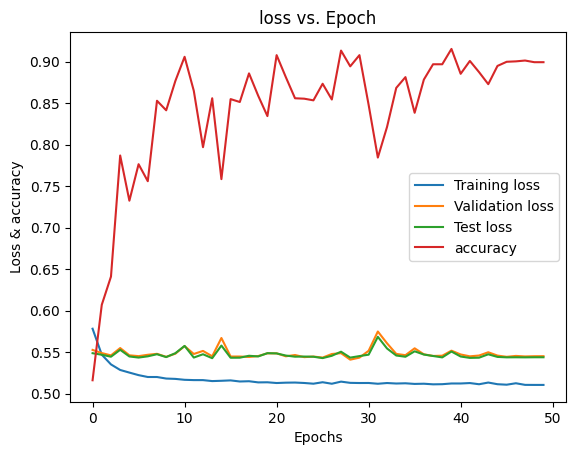

In [30]:
#5.2.1
print("in epochs = 50, batch_size = 4, k1 = 2, k2 = 4, n1 = 50, n2 = 80")
model_4, train_4, val_4, test_4, acc_4 = main(50,4,0.001,2,4,50,80)
plt.plot(train_4, label = "Training loss")
plt.plot(val_4, label = "Validation loss")
plt.plot(test_4, label = "Test loss")
plt.plot(acc_4, label = "accuracy")
plt.title("loss vs. Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss & accuracy")
plt.legend()
plt.show()

In [6]:
#5.1.2
def main_freeze(epochs,batch_size,learningrate,k1,k2,n1,n2):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    # 3.3.2
    train_dataset = TextDataset(glove, "train")
    test_dataset = TextDataset(glove, "test")

    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with
    model = cnnFreezeFalseModel(glove,100,k1,k2,n1,n2).to(device)
    # BCEWithLogitsLoss combines both sigmoid and binary corss-entropy
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningrate)

    total_trainloss = []
    for epoch in range(epochs):
        epoch_loss = 0
        for x_train,y_train in train_dataloader:
            optimizer.zero_grad()
            logits= model(x_train)
            loss = loss_function(logits, y_train.float())
            epoch_loss += loss.item()
            # backpropagate and update the weights
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_dataloader)}')
        total_trainloss.append(epoch_loss/len(train_dataloader))

    # test and accuracy after whole training
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x_test,y_test in test_dataloader:
            logits= model(x_test)
            loss = loss_function(logits, y_test.float())

            test_loss += loss.item()

            predicted_labels = (torch.sigmoid(logits) > 0.5).float()
            correct += (predicted_labels == y_test).sum().item()
            total += y_test.size(0)

    final_accuracy = correct/total
    print(f'After training, Accuracy: {final_accuracy}')

    return model, total_trainloss, final_accuracy

<Freeze = False >in epochs = 50, batch_size = 4, k1 = 2, k2 = 4, n1 = 50, n2 = 80
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Train Loss: 0.570897078756243
Epoch 2, Train Loss: 0.5289608446881175
Epoch 3, Train Loss: 0.515443719867617
Epoch 4, Train Loss: 0.5112367408163846
Epoch 5, Train Loss: 0.5086835966818035
Epoch 6, Train Loss: 0.5078371020406485
Epoch 7, Train Loss: 0.5067909936048091
Epoch 8, Train Loss: 0.5066595539450646
Epoch 9, Train Loss: 0.5060855624638498
Epoch 10, Train Loss: 0.5058306105062366
Epoch 11, Train Loss: 0.5051856392249465
Epoch 12, Train Loss: 0.5051240279339254
Epoch 13, Train Loss: 0.5049123788066209
Epoch 14, Train Loss: 0.5050689548254013
Epoch 15, Train Loss: 0.5047496351413429
Epoch 16, Train Loss: 0.5047451925650239
Epoch 17, Train Loss: 0.5047451455518603
Epoch 18, Train Loss: 0.5047450751252472
Epoch 19, Train Loss: 0.5046858116611839
Epoch 20, Train Loss: 0.5047742679528892
Epoch 21, Train Loss: 0.5049947455152869
Epoch 22, Train Loss: 0.5045671317912638
Epoch 23, Train Loss: 0.504567071609199
Epoch 24, Train Loss: 0.5045670711249113
Epoch 25, Train Loss: 0.5045

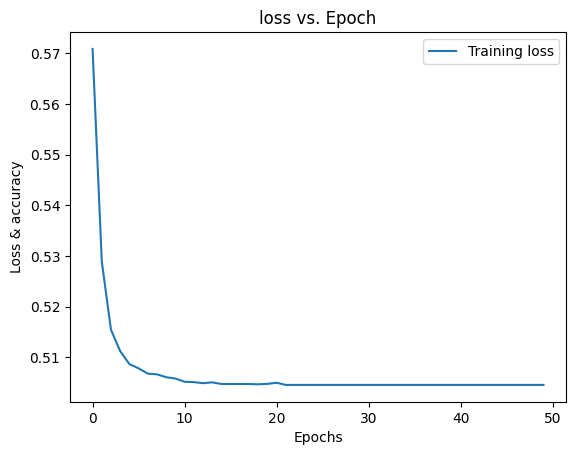

In [8]:
#5.2.2
print("<Freeze = False >in epochs = 50, batch_size = 4, k1 = 2, k2 = 4, n1 = 50, n2 = 80")
model_freeze, train_f, acc_f = main_freeze(50,4,0.001,2,4,50,80)
plt.plot(train_f, label = "Training loss")
plt.title("loss vs. Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss & accuracy")
plt.legend()
plt.show()

In [9]:
torch.save(model_freeze.state_dict(), '/content/CNNmodel.pt')

In [12]:
# 5.3
# conv1/conv2.weight shape: (n1/n2, 1, k1/k2, 100)
# precedure:
# choose first 3 kernels in conv1 and conv2,
 # each with(k1/k2, 100)average them into (1, 100)
# input into print_closest_cosine_words to find 5 closest words
def print_closest_cosine_words(vec, n=5):
    cosine_dists = torch.cosine_similarity(glove.vectors, vec)
    cosine_lst = sorted(enumerate(cosine_dists.numpy()), key=lambda x: x[1], reverse=True) # sort by cosine similarity
    for idx, difference in cosine_lst[1:n+1]:                         # take the top n
        print(glove.itos[idx], "\t%5.2f" % difference)

In [14]:
checkpoint = torch.load('/content/CNNmodel.pt')
net = cnnFreezeFalseModel(glove,100,2,4,50,80)
net.load_state_dict(checkpoint)
net.eval()

cnnFreezeFalseModel(
  (embeddings): Embedding(400000, 100)
  (conv1): Conv2d(1, 50, kernel_size=(2, 100), stride=(1, 1), bias=False)
  (conv2): Conv2d(1, 80, kernel_size=(4, 100), stride=(1, 1), bias=False)
  (relu): ReLU()
  (maxpool): AdaptiveMaxPool1d(output_size=1)
  (linear): Linear(in_features=130, out_features=1, bias=True)
)

In [13]:
for i in range(3):
    avg_conv1 = torch.mean(net.conv1.weight[i][:][:][:], dim = 1)
    avg_conv2 = torch.mean(net.conv2.weight[i][:][:][:], dim = 1)
    print(f"---the {i+1}th kernel in conv1 has following 5 closest words:---")
    print_closest_cosine_words(avg_conv1.detach(), n=5)
    print(f"---the {i+1}th kernel in conv2 has following 5 closest words:---")
    print_closest_cosine_words(avg_conv2.detach(), n=5)

---the 1th kernel in conv1 has following 5 closest words:---
tavernier 	 0.52
writer-director 	 0.50
imax 	 0.50
auteur 	 0.48
monodrama 	 0.48
---the 1th kernel in conv2 has following 5 closest words:---
befriended 	 0.49
17-year-old 	 0.49
kung-fu 	 0.48
recruited 	 0.47
kidnap 	 0.47
---the 2th kernel in conv1 has following 5 closest words:---
raided 	 0.40
according 	 0.39
temple 	 0.38
phalangist 	 0.38
centrebus 	 0.38
---the 2th kernel in conv2 has following 5 closest words:---
quantel 	 0.59
sextuplet 	 0.58
ayisha 	 0.57
66-acre 	 0.57
fin.k.l 	 0.56
---the 3th kernel in conv1 has following 5 closest words:---
obsessed 	 0.52
kung-fu 	 0.52
ex-husband 	 0.52
free-spirited 	 0.52
prostitute 	 0.50
---the 3th kernel in conv2 has following 5 closest words:---
teenager 	 0.43
hamilton 	 0.42
student 	 0.42
activist 	 0.40
recruited 	 0.40
